In [461]:
# import basic libraries
import pickle
import yt
import numpy as np
import matplotlib.pyplot as plt
from math import log, log10, pi
from astropy import units as u
from yt.utilities.cosmology import Cosmology

# import halo catalogue func
from yt.analysis_modules.halo_analysis.api import *

In [12]:
# import libraries - not sure what they do
# used to ensure halo catalog loads properly
import tempfile
import shutil
import os

# Create temporary directory for storing files
tmpdir = tempfile.mkdtemp()

In [281]:
# load halo dataset
halos_ds = yt.load('./LG4_2048_40pc/rd0110/halo_catalogs/catalog/catalog.0.h5')

# load raw dataset
ds = yt.load('~/../../tigress/cen/LG4_2048_40pc/RD0070/redshift0070')

# Instantiate a catalog using those two paramter files
hc = HaloCatalog(halos_ds=halos_ds, output_dir=os.path.join(tmpdir, 'halo_catalog'))
hc.load()

yt : [INFO     ] 2017-07-28 10:43:25,964 Parameters: current_time              = 6.86908772332e+16
yt : [INFO     ] 2017-07-28 10:43:25,966 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-07-28 10:43:25,970 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-28 10:43:25,973 Parameters: domain_right_edge         = [  3.33803289e+25   3.33803289e+25   3.33803289e+25]
yt : [INFO     ] 2017-07-28 10:43:25,977 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-28 10:43:25,979 Parameters: current_redshift          = 2.9999999666
yt : [INFO     ] 2017-07-28 10:43:25,981 Parameters: omega_lambda              = 0.712
yt : [INFO     ] 2017-07-28 10:43:25,983 Parameters: omega_matter              = 0.288
yt : [INFO     ] 2017-07-28 10:43:25,985 Parameters: hubble_constant           = 0.6933
yt : [INFO     ] 2017-07-28 10:43:26,042 Parameters: current_time              = 158.01757996843
yt : [INFO     ] 2017-07-28 10:43:26,044 Parame

In [462]:
redshift_filename = './LG4_2048_40pc/rd0070/redshift0070'

# load redshift and Omega values from parameter file
with open(redshift_filename, 'rt') as param_file:
    param_contents = param_file.read()
    
    #redshift
    cindex1 = param_contents.find('CosmologyCurrentRedshift')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    redshift = float(param_contents[cindex_eq+2:cindex2])
    
    # omega_m
    cindex1 = param_contents.find('CosmologyOmegaMatterNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    omega_m = float(param_contents[cindex_eq+2:cindex2])
    
    # hubble const now
    cindex1 = param_contents.find('CosmologyHubbleConstantNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    hubb_now = float(param_contents[cindex_eq+2:cindex2]) *(u.km / u.s / u.Mpc) 
    
    # cosmological constant
    cindex1 = param_contents.find('CosmologyOmegaLambdaNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    cos_const = float(param_contents[cindex_eq+2:cindex2])
    
    # omega baryon as specified by Renyue
    omega_b = 0.048
    
    # box size
    cindex1 = param_contents.find('CosmologyComovingBoxSize')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    box_size = float(param_contents[cindex_eq+2:cindex2]) * u.Mpc
    
    # left edge strings
    cindex1 = param_contents.find('RefineRegionLeftEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    left_edge_string = param_contents[cindex_eq+2:cindex2]
    left_edges = left_edge_string.split()
    
    # right edge strings
    cindex1 = param_contents.find('RefineRegionRightEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    right_edge_string = param_contents[cindex_eq+2:cindex2]
    right_edges = right_edge_string.split()
    
# calculate hubble const for simulation
hubb_z = (100* hubb_now.to('s**-1')) * ((omega_m * (1 + redshift)**3) + (1 - omega_m))**0.5

# calculate crit density and threshold
GRAV_CONST = (6.67408e-11 * u.m**3 /(u.kg * u.s**2)).to('cm^3*g^-1*s^-2')
crit_dens = (3 * hubb_z**2) / (8 * pi * GRAV_CONST)
omegas = (1 - (omega_b / omega_m))
threshold = 200 * omegas * crit_dens

# calculate current time
co = Cosmology(hubb_now.value, omega_m, cos_const)
time_now = co.hubble_time(redshift) * u.s

# min and max bounds for radial profile
# min = 1 kpc proper
# max = 0.5 Mpc comoving
# convert to centimeters value (without astropy units)
rad_min = 1 * u.kpc
rad_max = 0.5 * u.Mpc
rad_max = rad_max / (1 + redshift) # convert to physical

# specify boundaries of zoom-in box
# scaling factor multiplied by info from text file 
# units in cm
scaling =  ((box_size / hubb_now.value) / (1 + redshift)).to('kpc') # size of box
xmin = scaling*float(left_edges[0])
ymin = scaling*float(left_edges[1])
zmin = scaling*float(left_edges[2])
xmax = scaling*float(right_edges[0])
ymax = scaling*float(right_edges[1])
zmax = scaling*float(right_edges[2])

In [283]:
# --load ratio of stellar mass to halo mass
# first list uses first output of TotalMass funct
# second list uses second output

with open('./LG4_2048_40pc/rd0070/ratio_list0070_1.txt', 'rb') as ratiofile1:
    ratiolist1 = pickle.load(ratiofile1)
    
with open('./LG4_2048_40pc/rd0070/ratio_list0070_2.txt', 'rb') as ratiofile2:
    ratiolist2 = pickle.load(ratiofile2)
    
# load master calc list for LG35
with open('./master_calc0030', 'rb') as infile:
    halo_list = pickle.load(infile)

In [284]:
halo_list

[[4,
  4967,
  <Quantity 2730.2707368225533 kpc>,
  <Quantity 2747.750120971941 kpc>,
  <Quantity 2568.162295261254 kpc>,
  <Quantity 17621762811.334885 solMass>,
  <Quantity 13853352350.914053 solMass>,
  <Quantity 10.210570638324075 kpc>,
  <Quantity 22.09330767810782 kpc>,
  370,
  0,
  0,
  0,
  0,
  0],
 [7,
  4966,
  <Quantity 2812.5180462510234 kpc>,
  <Quantity 2848.2499824452275 kpc>,
  <Quantity 2664.8139402915654 kpc>,
  <Quantity 8702273964.894407 solMass>,
  <Quantity 8096654227.7456045 solMass>,
  <Quantity 8.070698947815933 kpc>,
  <Quantity 14.412224034413647 kpc>,
  1213,
  0,
  0,
  0,
  0,
  0],
 [10,
  4965,
  <Quantity 2979.6033034574075 kpc>,
  <Quantity 2406.291726076471 kpc>,
  <Quantity 2929.8603103096616 kpc>,
  <Quantity 8934947593.897242 solMass>,
  <Quantity 7299293197.986081 solMass>,
  <Quantity 8.14199629214509 kpc>,
  <Quantity 12.414740331582161 kpc>,
  2047,
  0,
  0,
  0,
  0,
  0],
 [11,
  4963,
  <Quantity 2910.375991406636 kpc>,
  <Quantity 2976.9

In [282]:
min_mass = 1e10 * u.Msun
mindex = 0

toSkip = (697, 825, 902, 914, 1111, 1211, 556)

count_agezero = 0
count_stelzero = 0
for halo in halo_list:
    mass = halo[5]
    rad = halo[7]
    stellar_mass = halo[11]
    ave_age = halo[12]
    
    if ave_age ==0:
        count_agezero +=1
    if stellar_mass == 0:
        count_stelzero +=1
    

count_agezero, count_stelzero, len(halo_list)

(620, 620, 1258)

In [488]:
# create new ratio lists
# < 3e7 Msun, < 3e8 Msun, > 3e8 Msun
# masks used to limit Msun to 3e7-3e8, 3e8-3e9
new_ratiolist11 = []
new_ratiolist12 = []
new_ratiolist13 = []
new_ratiolist21 = []
new_ratiolist22 = []
new_ratiolist23 = []
ave_agelist1 = []
ave_agelist2 = []
ave_agelist3 = []
proxlist1 = []
proxlist2 = []
proxlist3 = []
rad_ratiolist1 = []
rad_ratiolist2 = []
rad_ratiolist3 = []
peaklist1 = []
peaklist2 = []
peaklist3 = []

for halo in halo_list:
    # find parameters of halo
    x = halo[2]
    y = halo[3]
    z = halo[4]
    center = [(x/scaling).value, (y/scaling).value, (z/scaling).value]
    halo_mass = halo[5] # new mass
    radius = halo[7] # new radius
    isSatellite = halo[9]
    gas_mass = halo[10]
    stellar_mass = halo[11]
    ave_age = halo[12]
    prox = halo[13]
    stel_rad = halo[14]
    
    print(halo_mass, stellar_mass2, ave_age)

    # check that not a satellite 
    if isSatellite >= 0:
        print('IsSat')
        continue
    
#     # create a sphere data object with halo position and radius
#     sp = ds.sphere(center, (radius.to('cm').value, 'cm'))

#     # find the two output masses from TotalMass in Msun
#     masses = sp.quantities.total_mass()
#     gas_mass = masses[0] * u.g
#     particle_mass = masses[1] * u.g
#     gas_mass = gas_mass.to('Msun')
#     particle_mass = particle_mass.to('Msun')

#     # find stellar mass using total particle mass from TotalMass
#     stellar_mass = particle_mass.to('Msun') - (halo_mass*omegas).to('Msun')

    # create bools for simplification
    isAgeZero = (ave_age == 0)
    isStelMassZero = (stellar_mass == 0)
    
    # find the ratios
    if not isStelMassZero:
        ratio1 = gas_mass.to('Msun') / halo_mass.to('Msun')
        ratio2 = stellar_mass.to('Msun') / halo_mass.to('Msun')
    else:
        ratio1 = 5e-4
        ratio2 = 5e-7
    
    rad_ratio = (stel_rad / radius).value
    peak_height = (prox * halo_mass) + halo_mass
    
    # set aside the rad ratio of 1
    if isStelMassZero:
        rad_ratio = 5e-4
    
    print(ratio1, ratio2)
    print(isAgeZero, isStelMassZero)
    
    # append differently depending on ave_age == 0
    if isAgeZero and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(11)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(ratio2)
            ave_agelist1.append(1)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
            peaklist1.append(peak_height)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(12)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(ratio2)
            ave_agelist2.append(1)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
            peaklist2.append(peak_height)
        if halo_mass > 3e9 * u.Msun:
            print(13)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(ratio2)
            ave_agelist3.append(1)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)
            peaklist3.append(peak_height)
    if isAgeZero and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(21)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(5e-7)
            ave_agelist1.append(1)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
            peaklist1.append(peak_height)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(22)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(5e-7)
            ave_agelist2.append(1)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
            peaklist2.append(peak_height)
        if halo_mass > 3e9 * u.Msun:
            print(23)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(5e-7)
            ave_agelist3.append(1)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)
            peaklist3.append(peak_height)
    if (not isAgeZero) and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(31)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(5e-7)
            ave_agelist1.append(ave_age.to('Myr').value)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
            peaklist1.append(peak_height)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(32)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(5e-7)
            ave_agelist2.append(ave_age.to('Myr').value)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
            peaklist2.append(peak_height)
        if halo_mass > 3e9 * u.Msun:
            print(33)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(5e-7)
            ave_agelist3.append(ave_age.to('Myr').value)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)
            peaklist3.append(peak_height)
    if (not isAgeZero) and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(4)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(ratio2.value)
            ave_agelist1.append(ave_age.to('Myr').value)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
            peaklist1.append(peak_height)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(5)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(ratio2.value)
            ave_agelist2.append(ave_age.to('Myr').value)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
            peaklist2.append(peak_height)
        if halo_mass > 3e9 * u.Msun:
            print(6)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(ratio2.value)
            ave_agelist3.append(ave_age.to('Myr').value)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)
            peaklist3.append(peak_height)

# get values for peak heights
new_peaklist1 = []
new_peaklist2 = []
new_peaklist3 = []
for peak in peaklist1:
    new_peaklist1.append(peak.value)
for peak in peaklist2:
    new_peaklist2.append(peak.value)
for peak in peaklist3:
    new_peaklist3.append(peak.value)

# convert peaklist to arrays
new_peaklist1 = np.array(new_peaklist1)
new_peaklist2 = np.array(new_peaklist2)
new_peaklist3 = np.array(new_peaklist3)

17621762811.334885 solMass 0 0
IsSat
8702273964.894407 solMass 0 0
IsSat
8934947593.897242 solMass 0 0
IsSat
8347772528.409236 solMass 0 4642639427382311.0 s
0.16091709327873627 0.03308321306553944
False False
6
5399513868.685906 solMass 0 2115773475975433.8 s
0.17677969573885388 0.009944773650636592
False False
6
5227243298.307006 solMass 0 4462673294060465.0 s
0.18613301793320383 0.050915387563851125
False False
6
3636922802.3817005 solMass 0 5626609473605192.0 s
0.1988612880493135 0.03977412688806161
False False
6
3327387007.470943 solMass 0 5211699927504760.0 s
0.15151359941156547 0.010118489105393317
False False
6
3690627970.1274734 solMass 0 4139291223499111.0 s
0.18135227765310202 0.01073402230032498
False False
6
3774322776.5925403 solMass 0 5179022952707590.0 s
0.16285896151778495 0.02675391139182708
False False
6
3059504917.277112 solMass 0 0
IsSat
3793885487.2581296 solMass 0 2064740511768792.8 s
0.1867814514821169 0.0025048717937183615
False False
6
3271099738.0723395 solMa

False False
5
613346790.4944055 solMass 0 5336394052479888.0 s
0.2987414733127014 0.01591821158311028
False False
5
609774852.5215887 solMass 0 5424260834441625.0 s
0.33792293419287184 0.003225440341678879
False False
5
746183408.3235288 solMass 0 4945122406230510.0 s
0.23432106204438036 0.0069375821491210205
False False
5
712578901.1430227 solMass 0 3133773241520848.5 s
0.3879764797802628 0.0014140260727049162
False False
5
682469804.5224564 solMass 0 1.1730198107140692e+16 s
0.17070498353028932 0.000283115110189554
False False
5
637962771.1035118 solMass 0 2056685162914983.0 s
0.24993967810271242 0.001537241248705664
False False
5
562235072.8587693 solMass 0 2148608923760299.2 s
0.2615241720147796 0.0039303724406787865
False False
5
533356173.3382977 solMass 0 2928114957388642.5 s
0.309998619533548 0.0003249020416614458
False False
5
717002756.4410168 solMass 0 1683217737053081.5 s
0.19263678691288003 9.619731125495338e-05
False False
5
0.0 solMass 0 0


/home/ygovil/anaconda/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


0.0005 5e-07
True True
689770987.7105184 solMass 0 3265306886347962.0 s
0.245365298049624 0.0015850691884945352
False False
5
562786961.6574872 solMass 0 2792203723618321.5 s
0.2828536622761356 0.010439259963202127
False False
5
855845008.334588 solMass 0 0.0 s
0.0005 5e-07
True True
22
754577170.7671052 solMass 0 1759026802096670.2 s
0.179006001839173 0.0004039649317855827
False False
5
509562422.0977856 solMass 0 2185850118343300.5 s
0.30807847976174146 0.006885795038136469
False False
5
408665220.17772996 solMass 0 1977340017366925.2 s
0.3021913720807335 0.004268866461109199
False False
5
798347392.0455551 solMass 0 710275732616681.6 s
0.2303435372461553 0.00027525368130678317
False False
5
582295186.4777638 solMass 0 7690983043395597.0 s
0.16794224131018937 0.0011802900060547106
False False
5
496664053.38290966 solMass 0 5735165010162454.0 s
0.2997922233928277 0.011025520211722362
False False
5
646632793.6397247 solMass 0 4202223691326039.5 s
0.1754526945456629 0.001452167876073779

0.18924993550175997 0.0009709087798721101
False False
5
475229258.8078312 solMass 0 0.0 s
0.0005 5e-07
True True
22
461779194.0634102 solMass 0 0
IsSat
319391087.21641415 solMass 0 1145648992314820.0 s
0.18114657222854866 0.00026918494928810066
False False
5
431277815.6527038 solMass 0 0.0 s
0.0005 5e-07
True True
22
386646558.9012824 solMass 0 2447926758226789.0 s
0.2022271906979373 7.792308177993541e-05
False False
5
446437574.6622691 solMass 0 1728810029170205.0 s
0.24533996036053876 0.0006098668596075776
False False
5
447402791.4013006 solMass 0 475094746171042.8 s
0.16163784246963595 6.848163890655747e-05
False False
5
447990589.9030183 solMass 0 5552678786587306.0 s
0.2523536147456466 0.008000060750285167
False False
5
430969618.4840279 solMass 0 0.0 s
0.0005 5e-07
True True
22
318650403.73414755 solMass 0 4283005349534013.5 s
0.431853221127053 0.006749195906051713
False False
5
355619875.85898906 solMass 0 1220971660969715.5 s
0.19766583371211577 0.002251039784403162
False False

0.24462131467417073 0.0011170221173266253
False False
4
429444885.8623354 solMass 0 1.133833267766547e+16 s
0.23683002781841186 0.0002159634674854337
False False
5
396678318.03083545 solMass 0 4421682143335404.0 s
0.22466863865680067 0.00033771481038296074
False False
5
310895636.49756247 solMass 0 2826348692507266.5 s
0.222503431671475 0.00331660524432178
False False
5
263889513.771508 solMass 0 1918883762848764.8 s
0.24083647504666164 0.00010072486664906548
False False
4
249333207.64502624 solMass 0 0.0 s
0.0005 5e-07
True True
21
320398848.0229088 solMass 0 0.0 s
0.0005 5e-07
True True
22
329407332.55296755 solMass 0 0.0 s
0.0005 5e-07
True True
22
231613028.88578218 solMass 0 930048940979454.1 s
0.299880838391556 0.0027022965577623397
False False
4
244345184.55814797 solMass 0 6639753735187886.0 s
0.24635206550342356 0.0007368430967059924
False False
4
203824114.4080042 solMass 0 3649910317715396.5 s
0.3787688645221719 0.000328626824511442
False False
4
282814566.61824924 solMass 0

156504453.89324215 solMass 0 2038889564499953.2 s
0.47826950265790585 0.0003775262771137444
False False
4
171500032.1958191 solMass 0 3697632147590.0 s
0.37768768738325514 3.994166719147728e-05
False False
4
182233469.9576123 solMass 0 1549756764265684.8 s
0.3314215457549552 0.0002589591811424236
False False
4
163837819.0909798 solMass 0 0.0 s
0.0005 5e-07
True True
21
196620277.19582728 solMass 0 0.0 s
0.0005 5e-07
True True
21
203078749.0001065 solMass 0 0.0 s
0.0005 5e-07
True True
21
184005536.8806251 solMass 0 0.0 s
0.0005 5e-07
True True
21
135696298.25440413 solMass 0 1.1936902697915176e+16 s
0.4570326098064277 0.0013099849815792063
False False
4
151707446.41343832 solMass 0 2012434536837595.0 s
0.3248034861916754 0.00030984533823820036
False False
4
186895070.36362597 solMass 0 3769803627347008.0 s
0.14486868163560296 1.3784384539006488e-05
False False
4
170380540.67138463 solMass 0 0.0 s
0.0005 5e-07
True True
21
172551469.5014627 solMass 0 0.0 s
0.0005 5e-07
True True
21
1868

119511516.22901306 solMass 0 0.0 s
0.0005 5e-07
True True
21
147237034.40070665 solMass 0 1.2398952189264688e+16 s
0.032397747394403355 0.0026945663734584007
False False
4
254947167.84832066 solMass 0 0.0 s
0.0005 5e-07
True True
21
98929045.88438155 solMass 0 0.0 s
0.0005 5e-07
True True
21
133555996.2564809 solMass 0 0.0 s
0.0005 5e-07
True True
21
130755391.46871667 solMass 0 1461927872463960.8 s
0.3538580319053528 0.0007101444004803314
False False
4
105507366.66454248 solMass 0 3763871233360754.0 s
0.3989335311013542 4.883514013818492e-05
False False
4
0.0 solMass 0 0
0.0005 5e-07
True True
136482652.9249047 solMass 0 0.0 s
0.0005 5e-07
True True
21
198395926.93684322 solMass 0 0.0 s
0.0005 5e-07
True True
21
110370363.35966912 solMass 0 0.0 s
0.0005 5e-07
True True
21
115653174.5027845 solMass 0 3734394293435291.0 s
0.3496177712671974 8.91020425306136e-05
False False
4
90541922.46472181 solMass 0 0.0 s
0.0005 5e-07
True True
21
178389462.3781803 solMass 0 0.0 s
0.0005 5e-07
True T

133858054.63820547 solMass 0 0.0 s
0.0005 5e-07
True True
21
78063940.66633411 solMass 0 1028699415515657.0 s
0.8363708303703117 0.0015673319794374631
False False
4
80050444.00395632 solMass 0 0.0 s
0.0005 5e-07
True True
21
144291493.95776558 solMass 0 0.0 s
0.0005 5e-07
True True
21
72194906.41187003 solMass 0 0.0 s
0.0005 5e-07
True True
21
59967831.766078606 solMass 0 0.0 s
0.0005 5e-07
True True
21
65392668.45262646 solMass 0 0.0 s
0.0005 5e-07
True True
21
88957558.29497372 solMass 0 0.0 s
0.0005 5e-07
True True
21
84904469.89196986 solMass 0 5601014540618050.0 s
0.3312104092053292 0.005350702747914843
False False
4
91850975.57351336 solMass 0 0.0 s
0.0005 5e-07
True True
21
27884792.471491646 solMass 0 0.0 s
0.0005 5e-07
True True
124829424.45240356 solMass 0 0.0 s
0.0005 5e-07
True True
21
90145599.4186816 solMass 0 2083469421313058.2 s
0.4337659735081743 0.0004957649786974541
False False
4
88844351.02743623 solMass 0 0.0 s
0.0005 5e-07
True True
21
97875119.01257348 solMass 0 

True True
21
76832701.55420391 solMass 0 0.0 s
0.0005 5e-07
True True
21
62960124.62557325 solMass 0 0.0 s
0.0005 5e-07
True True
21
95629081.8888376 solMass 0 0.0 s
0.0005 5e-07
True True
21
34849691.363067664 solMass 0 0.0 s
0.0005 5e-07
True True
21
76285829.06154484 solMass 0 0.0 s
0.0005 5e-07
True True
21
71786147.17166899 solMass 0 0.0 s
0.0005 5e-07
True True
21
98946314.8492408 solMass 0 0.0 s
0.0005 5e-07
True True
21
56830138.194691725 solMass 0 0.0 s
0.0005 5e-07
True True
21
82039139.49579006 solMass 0 0.0 s
0.0005 5e-07
True True
21
83265172.52325703 solMass 0 0.0 s
0.0005 5e-07
True True
21
63838045.120013304 solMass 0 0.0 s
0.0005 5e-07
True True
21
106272405.23043336 solMass 0 0.0 s
0.0005 5e-07
True True
21
90517411.99528353 solMass 0 0.0 s
0.0005 5e-07
True True
21
75533254.96589513 solMass 0 0.0 s
0.0005 5e-07
True True
21
74447916.45172353 solMass 0 0.0 s
0.0005 5e-07
True True
21
131433846.75232753 solMass 0 0.0 s
0.0005 5e-07
True True
21
75956653.66009057 solMas

49568164.959608294 solMass 0 0.0 s
0.0005 5e-07
True True
21
70876331.42154108 solMass 0 0.0 s
0.0005 5e-07
True True
21
60997544.99257156 solMass 0 0.0 s
0.0005 5e-07
True True
21
73472071.02569242 solMass 0 0.0 s
0.0005 5e-07
True True
21
51481454.90590482 solMass 0 0.0 s
0.0005 5e-07
True True
21
43059596.18926041 solMass 0 0.0 s
0.0005 5e-07
True True
21
68666132.11793523 solMass 0 0.0 s
0.0005 5e-07
True True
21
46100700.61843173 solMass 0 0.0 s
0.0005 5e-07
True True
21
81914882.64976224 solMass 0 0.0 s
0.0005 5e-07
True True
21
60639661.76406409 solMass 0 0.0 s
0.0005 5e-07
True True
21
28547663.792924546 solMass 0 0.0 s
0.0005 5e-07
True True
67855798.10187913 solMass 0 0.0 s
0.0005 5e-07
True True
21
66174698.85878675 solMass 0 0.0 s
0.0005 5e-07
True True
21
57287257.77111212 solMass 0 0.0 s
0.0005 5e-07
True True
21
41539947.83734285 solMass 0 0.0 s
0.0005 5e-07
True True
21
99810614.72987731 solMass 0 0.0 s
0.0005 5e-07
True True
21
45020459.04806635 solMass 0 0.0 s
0.0005 

21
42470479.88608466 solMass 0 0.0 s
0.0005 5e-07
True True
21
45950048.18043378 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
96438007.67175715 solMass 0 0.0 s
0.0005 5e-07
True True
21
35290500.67581461 solMass 0 0.0 s
0.0005 5e-07
True True
21
28410982.236690976 solMass 0 0.0 s
0.0005 5e-07
True True
26899076.218839977 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
47993278.0596046 solMass 0 0.0 s
0.0005 5e-07
True True
21
50310242.16003666 solMass 0 0.0 s
0.0005 5e-07
True True
21
57220771.51647406 solMass 0 0.0 s
0.0005 5e-07
True True
21
48135502.61582383 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
75526079.84846988 solMass 0 0.0 s
0.0005 5e-07
True True
21
45559504.31071638 solMass 0 0.0 s
0.0005 5e-07
True True
21
61906902.71546498 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
32165983.198195696 solMass 0 0.0 s
0.0005 5e-07
True True
21
30547

58096997.64251673 solMass 0 0.0 s
0.0005 5e-07
True True
21
44567396.14283864 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
23762107.535892833 solMass 0 0.0 s
0.0005 5e-07
True True
25298508.560198437 solMass 0 0.0 s
0.0005 5e-07
True True
34416758.10557976 solMass 0 0.0 s
0.0005 5e-07
True True
21
46398354.625087045 solMass 0 0.0 s
0.0005 5e-07
True True
21
73845376.90379278 solMass 0 0.0 s
0.0005 5e-07
True True
21
34686734.11414567 solMass 0 0.0 s
0.0005 5e-07
True True
21
42325264.098092474 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
36582540.80084024 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
49154279.67780815 solMass 0 0.0 s
0.0005 5e-07
True True
21
29067982.223793473 solMass 0 0.0 s
0.0005 5e-07
True True
51558528.92034814 solMass 0 0.0 s
0.0005 5e-07
True True
21
23553792.455650028 solMass 0 0.0 s
0.0005 5e-07
True True
39930713.842092104 solMass 0 0.0 s
0.0005 5e-07
T

25863347.69430957 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23240494.5818406 solMass 0 0.0 s
0.0005 5e-07
True True
26600270.73754244 solMass 0 0.0 s
0.0005 5e-07
True True
33849222.76916055 solMass 0 0.0 s
0.0005 5e-07
True True
21
31582644.693912853 solMass 0 0.0 s
0.0005 5e-07
True True
21
26001954.85477246 solMass 0 0.0 s
0.0005 5e-07
True True
46008722.21590799 solMass 0 0.0 s
0.0005 5e-07
True True
21
23437385.635905843 solMass 0 0.0 s
0.0005 5e-07
True True
28616430.491313953 solMass 0 0.0 s
0.0005 5e-07
True True
45554370.162107155 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
39424135.72298777 solMass 0 0.0 s
0.0005 5e-07
True True
21
37264914.65682932 solMass 0 0.0 s
0.0005 5e-07
True True
21
31315556.08113896 solMass 0 0.0 s
0.0005 5e-07
True True
21
23522845.23673099 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26990821.92081404 solM

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
20290747.63759099 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
52551484.28846141 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
42840137.17850425 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
36411055.67526071 solMass 0 0.0 s
0.0005 5e-07
True True
21
23093699.27407947 solMass 0 0.0 s
0.0005 5e-07
True True
30927333.550935738 solMass 0 0.0 s
0.0005 5e-07
True True
21
35198815.241632015 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07

True True
27156508.103394516 solMass 0 0.0 s
0.0005 5e-07
True True
51640972.69541633 solMass 0 0.0 s
0.0005 5e-07
True True
21
38887070.11431794 solMass 0 0.0 s
0.0005 5e-07
True True
21
27005289.696424626 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
20286011.684370834 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
35194161.08621992 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22559351.158507396 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22444734.37774975 solMass 0 0.0 

38346269.97099707 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23388233.065048613 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29687736.183616985 solMass 0 0.0 s
0.0005 5e-07
True True
28479847.74770115 solMass 0 0.0 s
0.0005 5e-07
True True
32161251.679129697 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
2466175231.7327013 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
16829839567.759224 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07


True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23694079.55863849 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True Tr

False False
5
1397281778.050332 solMass 0 1121472449194628.0 s
0.2531483386002159 0.0070085917140479985
False False
5
1294572584.789848 solMass 0 4216896001993262.5 s
0.296250907499137 0.02380112892289437
False False
5
1091593529.8869686 solMass 0 3740679975590727.5 s
0.32433842292335247 0.016315819830422393
False False
5
1003016855.0895587 solMass 0 4054333811050300.5 s
0.18328405175780538 0.015420663457916465
False False
5
1217517205.842905 solMass 0 4685699597279185.0 s
0.24873710139224667 0.000853293548362218
False False
5
922645361.2609657 solMass 0 3391312737126634.5 s
0.28403242464986034 0.0031448690250214448
False False
5
964472481.8030058 solMass 0 2510873955912185.5 s
0.21497262293460745 0.00811116002570102
False False
5
1014170558.68821 solMass 0 7085741737502756.0 s
0.13052974852640734 0.0034919301535010832
False False
5
1249826834.3362062 solMass 0 3542929996201442.5 s
0.19806633774812657 0.0003833531976506999
False False
5
1211621707.3723526 solMass 0 4162956387074504.5 s

0.30082808465906685 0.003907151796862024
False False
4
359214597.48708236 solMass 0 3739923285874524.0 s
0.33705524581156215 0.0007690686621766424
False False
5
450259596.9101409 solMass 0 8350723760068751.0 s
0.08515525773411078 0.0035417091802287977
False False
5
441911678.0118116 solMass 0 1763998765962386.0 s
0.23901733323824453 0.0013264243619058656
False False
5
332532879.4728529 solMass 0 2562466412127083.0 s
0.3350374916719087 0.010786858021848963
False False
5
297958573.2424399 solMass 0 6288210613353699.0 s
0.35904533673410893 0.015192315206881997
False False
4
289050146.6173734 solMass 0 8824449730888585.0 s
0.40505543805272937 0.0422445290275844
False False
4
381684173.89007676 solMass 0 3010953142605499.5 s
0.22497012885898335 0.000735043615967551
False False
5
348049186.1459137 solMass 0 1994405105777561.8 s
0.23346446093679582 0.0004510429200221129
False False
5
340631774.1560744 solMass 0 1.2211157643077002e+16 s
0.20660967619294393 0.0005142910689629049
False False
5
3

True True
21
218120361.1281928 solMass 0 0.0 s
0.0005 5e-07
True True
21
190626264.7705666 solMass 0 1.1740211823210796e+16 s
0.2513644069012313 0.001088775979577225
False False
4
208749127.81354362 solMass 0 0.0 s
0.0005 5e-07
True True
21
204769581.12549642 solMass 0 0.0 s
0.0005 5e-07
True True
21
164304801.34033984 solMass 0 2999187665432913.0 s
0.28519918584834697 0.00012543679782361336
False False
4
297105586.4984675 solMass 0 1291868554854294.5 s
0.17620817907616176 1.7446091413892815e-05
False False
4
230295213.36096302 solMass 0 0.0 s
0.0005 5e-07
True True
21
188585482.84353158 solMass 0 3091938458085863.5 s
0.29592323745019483 0.005535009368324058
False False
4
171572116.0155283 solMass 0 0.0 s
0.0005 5e-07
True True
21
170857368.2009451 solMass 0 0.0 s
0.0005 5e-07
True True
21
318445403.6089641 solMass 0 0.0 s
0.0005 5e-07
True True
22
212438299.02737778 solMass 0 2938276654583302.0 s
0.21985435641000656 0.0004123170823044513
False False
4
223724077.24852887 solMass 0 0.0 

84939627.91373841 solMass 0 0.0 s
0.0005 5e-07
True True
21
129994969.89222589 solMass 0 1292904621187876.0 s
0.1756235749995834 1.9936660725902766e-05
False False
4
138137623.09794807 solMass 0 1.1607657475494882e+16 s
0.13323709988312102 0.007366655200878513
False False
4
121384788.17698579 solMass 0 3377675632202524.5 s
0.27855354796579734 0.00040426724242582327
False False
4
104674926.63595277 solMass 0 0.0 s
0.0005 5e-07
True True
21
136110790.24258015 solMass 0 0.0 s
0.0005 5e-07
True True
21
93757015.21033745 solMass 0 1206124146338770.2 s
0.28234805918909883 8.473765757030745e-05
False False
4
103382531.29814222 solMass 0 5971643279584293.0 s
0.5789424854275979 0.0002251704802262643
False False
4
121837595.12916991 solMass 0 2942733399301375.5 s
0.4011274949805403 0.0011236188481668038
False False
4
163495986.94387734 solMass 0 0.0 s
0.0005 5e-07
True True
21
112131396.53634426 solMass 0 1292744215096652.0 s
0.2673650431367952 9.286389933903134e-05
False False
4
181881564.31897

True True
21
71223171.0271405 solMass 0 0
IsSat
67190345.93854477 solMass 0 5567907964073698.0 s
0.2788915578135375 0.000767765041497465
False False
4
70600278.79777373 solMass 0 2711093274907389.5 s
0.2689481983290967 0.00011012699900005821
False False
4
80848520.98202391 solMass 0 0.0 s
0.0005 5e-07
True True
21
116285753.58958632 solMass 0 2348423515822160.5 s
0.1426069904733051 8.86173392303531e-05
False False
4
71485949.69266465 solMass 0 0.0 s
0.0005 5e-07
True True
21
72954803.71595655 solMass 0 0.0 s
0.0005 5e-07
True True
21
68129017.41915078 solMass 0 0.0 s
0.0005 5e-07
True True
21
83083000.0996752 solMass 0 0.0 s
0.0005 5e-07
True True
21
71602274.95858094 solMass 0 9152189508063276.0 s
0.47282264210170605 0.0031306712031194425
False False
4
123261719.85310493 solMass 0 0.0 s
0.0005 5e-07
True True
21
89452749.37717818 solMass 0 0.0 s
0.0005 5e-07
True True
21
127069219.9256754 solMass 0 0.0 s
0.0005 5e-07
True True
21
35507318.77806601 solMass 0 0.0 s
0.0005 5e-07
True Tru

0.0 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
54651204.40552532 solMass 0 0.0 s
0.0005 5e-07
True True
21
50418261.110756196 solMass 0 0.0 s
0.0005 5e-07
True True
21
73317505.347422 solMass 0 0.0 s
0.0005 5e-07
True True
21
56016375.176811256 solMass 0 0.0 s
0.0005 5e-07
True True
21
74955765.55546561 solMass 0 0.0 s
0.0005 5e-07
True True
21
57196707.81471411 solMass 0 0.0 s
0.0005 5e-07
True True
21
48115478.62830962 solMass 0 0.0 s
0.0005 5e-07
True True
21
65523818.20279864 solMass 0 0.0 s
0.0005 5e-07
True True
21
60077265.396667376 solMass 0 1293685041496971.8 s
0.2715925627144288 0.00013044410644552916
False False
4
54625601.68600032 solMass 0 0.0 s
0.0005 5e-07
True True
21
61114985.50608825 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
36398714.756806314 solMass 0 0.0 s
0.0005 5e-07
True True
21
45011035.03620615 solMass 0 0.0 s
0.0005 5e-07
True True
21
34647831.0404318 solMass 0 0.0 s
0.0005 5e-07
True True
21
21551479.03857

32179551.621137686 solMass 0 0.0 s
0.0005 5e-07
True True
21
49575679.61935206 solMass 0 0.0 s
0.0005 5e-07
True True
21
31580900.200982854 solMass 0 0.0 s
0.0005 5e-07
True True
21
38971068.679794006 solMass 0 0.0 s
0.0005 5e-07
True True
21
24246565.809312776 solMass 0 0.0 s
0.0005 5e-07
True True
41335497.16954232 solMass 0 0.0 s
0.0005 5e-07
True True
21
42284420.6909937 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
43401381.37515397 solMass 0 0.0 s
0.0005 5e-07
True True
21
29206052.741807923 solMass 0 0.0 s
0.0005 5e-07
True True
37249018.56639682 solMass 0 0.0 s
0.0005 5e-07
True True
21
49068482.16232449 solMass 0 0.0 s
0.0005 5e-07
True True
21
43746087.10359573 solMass 0 0.0 s
0.0005 5e-07
True True
21
49835578.88421109 solMass 0 0.0 s
0.0005 5e-07
True True
21
43675217.27043499 solMass 0 0.0 s
0.0005 5e-07
True True
21
32597526.14411875 solMass 0 0.0 s
0.0005 5e-07
True True
21
30677699.985060025 solMass 0 0.0 s
0.0005 5e-07
True True
21
55

26434741.418361332 solMass 0 0.0 s
0.0005 5e-07
True True
45224338.688843645 solMass 0 0.0 s
0.0005 5e-07
True True
21
29611072.453185923 solMass 0 0.0 s
0.0005 5e-07
True True
38932364.046320885 solMass 0 0.0 s
0.0005 5e-07
True True
21
39017922.82510728 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
35432882.08135497 solMass 0 0.0 s
0.0005 5e-07
True True
21
32215362.014301535 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
30484497.438433807 solMass 0 0.0 s
0.0005 5e-07
True True
21
23636254.33674625 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
28254980.638990264 solMass 0 0.0 s
0.0005 5e-07
True True
36918872.05666508 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
40522497.667916335 solMass 0 0.0 s
0.0005 5e-07
True True
21
34958862.40294496 solMass 0 0.0 s
0.0005 5e-07
True True
21
37350312.9697403 solMass 0 0.0 s
0.0005 5e-07
True True
21
29662706.

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
31050467.497330785 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29273153.506684855 solMass 0 0.0 s
0.0005 5e-07
True True
41601487.93166467 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27650185.070840847 solMass 0 0.0 s
0.0005 5e-07
True True
25936615.320930116 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
40064689.46104763 solMass 0 0.0 s
0.0005 5e-07
True True
21
22400115.50388146 solMass 0 0.0 s
0.0005 5e-07
True True
24113409.29307334 solMass 0 0.0 s
0.0005 5e-07
True True
22461662.208213683 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.000

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
20400208.124336623 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25130900.703749035 solMass 0 0.0 s
0.0005 5e-07
True True
26907881.837387122 solMass 0 0.0 s
0.0005 5e-07
True True
25398905.997447472 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22609875.758472886 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22934283.547799785 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22392292.817010976 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMa

True True
23138259.333784536 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30534228.434911 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22099752.23650495 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
34177809.72291161 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0


0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27978054.68488227 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30290089.809782192 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27829083.939172473 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True T

22265767.02275762 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 sol

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
Tru

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
20279553905.301

False False
5
976831595.0860385 solMass 0 2726274445672165.5 s
0.2676814683145011 0.012426149929045446
False False
5
855013303.237199 solMass 0 3835486575480238.5 s
0.3005151094359771 0.004197941780510324
False False
5
880441654.0747085 solMass 0 4362434128322726.5 s
0.25112639563302086 0.011810054561109907
False False
5
862935073.5364081 solMass 0 2075322788610110.0 s
0.20955490605000024 0.00015281353163078078
False False
5
677776453.8534329 solMass 0 5928852752856304.0 s
0.2635104406538004 0.01731363650873956
False False
5
966125742.5273006 solMass 0 5139535014055196.0 s
0.23109419479585083 0.012826219603079917
False False
5
1205475822.3890886 solMass 0 1810330241848934.2 s
0.17768376249914616 5.173944797939522e-05
False False
5
1040047306.4764318 solMass 0 2589817599327152.5 s
0.17274780267641934 0.0003083464848708129
False False
5
876004323.1036137 solMass 0 3247361081046483.0 s
0.1979323242432932 0.008371604253881662
False False
5
885334092.8164943 solMass 0 4167315653107202.5 s
0

464633214.32693785 solMass 0 4035777420660106.0 s
0.2660211067484569 0.008375731754856832
False False
5
533138023.6369184 solMass 0 3442957517502276.5 s
0.3272831680533484 0.0012063220575829036
False False
5
492407101.43596864 solMass 0 3100576544187967.0 s
0.242526808898913 0.00042451181203806453
False False
5
531045437.10269344 solMass 0 1846347196790226.0 s
0.36548551882019276 0.009897977214535232
False False
5
575484459.2635235 solMass 0 1299621753550182.8 s
0.14836655916026972 8.484313563866117e-05
False False
5
501267737.1279106 solMass 0 2340336278731711.5 s
0.190613694528067 0.000277719809194285
False False
5
481949759.9330374 solMass 0 2400333761604133.0 s
0.18964572134170646 0.0008534170729297655
False False
5
643629622.7094066 solMass 0 1119857992658181.5 s
0.15760260460256711 5.119689533280834e-05
False False
5
400487779.20988995 solMass 0 9650439696312718.0 s
0.3613543245160079 0.002216797369681664
False False
5
675560803.9775227 solMass 0 1838863407663360.0 s
0.2124043345

0.24683790260179014 0.000580039919986353
False False
5
291616603.36709774 solMass 0 2038672889817890.5 s
0.31543534552565666 0.0015925086771105697
False False
4
330911504.43547094 solMass 0 0.0 s
0.0005 5e-07
True True
22
331199881.4910109 solMass 0 7230818724037578.0 s
0.35481053351823005 0.0020017294884934265
False False
5
433765293.7442136 solMass 0 2012348901729198.2 s
0.22389212866182467 0.0004668933698189539
False False
5
327902720.1452086 solMass 0 3541047504687577.5 s
0.23876410933722553 0.0026431495986662047
False False
5
303042907.53335106 solMass 0 0.0 s
0.0005 5e-07
True True
22
276906618.32225466 solMass 0 5062677973757168.0 s
0.26966589201131996 0.000526519933213262
False False
4
403633940.60863703 solMass 0 1866506385616035.0 s
0.219408385859858 0.00036668936413107573
False False
5
466992707.7317542 solMass 0 0.0 s
0.0005 5e-07
True True
22
380092164.46427023 solMass 0 1.2270907742532714e+16 s
0.13887156197021824 0.00042834866361660237
False False
5
325494706.729185 solM

0.20182764706148332 0.00011401743214170706
False False
5
225453298.5973957 solMass 0 801030081139835.0 s
0.27446681235301945 6.30896053674587e-05
False False
4
266779781.54371455 solMass 0 3411888880705278.0 s
0.15904123259431746 1.9313558947317324e-05
False False
4
245486583.14239937 solMass 0 4242109986775338.5 s
0.2494594827188762 0.0022281890555501714
False False
4
264671834.29610685 solMass 0 2119083340903778.0 s
0.18147779261043853 0.00020510716276422877
False False
4
182011147.02070895 solMass 0 1088447483179504.0 s
0.2945671983228226 1.5002127549966955e-05
False False
4
238744838.5787966 solMass 0 3267982961213707.5 s
0.27320258637149797 0.003079791264327884
False False
4
224512943.2068124 solMass 0 0.0 s
0.0005 5e-07
True True
21
199204684.5769907 solMass 0 2436489317419616.0 s
0.42749768210317923 0.004252273508527638
False False
4
254431603.55981234 solMass 0 1083415862952884.0 s
0.18007312834030828 1.0671325073828063e-05
False False
4
205290044.13437885 solMass 0 12295451085

True True
21
136065090.00677377 solMass 0 6990252485566358.0 s
0.42140095597773414 0.0008376252756209574
False False
4
269111655.5447 solMass 0 0.0 s
0.0005 5e-07
True True
21
187584653.0506932 solMass 0 0.0 s
0.0005 5e-07
True True
21
173358316.8191516 solMass 0 988982157797432.9 s
0.4456505647693365 0.00037882344886692657
False False
4
143013387.99201047 solMass 0 3548948580995258.0 s
0.6256104665090725 0.006524244075975119
False False
4
190913300.40085912 solMass 0 0.0 s
0.0005 5e-07
True True
21
210767979.43177631 solMass 0 0.0 s
0.0005 5e-07
True True
21
176901120.70994973 solMass 0 2817190720732012.0 s
0.4954712239479947 0.0009281197670292752
False False
4
199997363.2001347 solMass 0 8367179670699427.0 s
0.26037364095614046 0.002062030975072299
False False
4
176447919.20429686 solMass 0 982003984951428.2 s
0.29626173417613694 0.00010911304605330604
False False
4
167559953.60381028 solMass 0 2473155242685495.5 s
0.35966421845726637 0.006409921608750341
False False
4
178031729.4550

114438110.54786232 solMass 0 0.0 s
0.0005 5e-07
True True
21
122713072.0661624 solMass 0 1411440754832106.5 s
0.3969956739684225 0.00026802450222694515
False False
4
161164476.4541288 solMass 0 0.0 s
0.0005 5e-07
True True
21
147065223.4082542 solMass 0 0.0 s
0.0005 5e-07
True True
21
156586614.72208464 solMass 0 0.0 s
0.0005 5e-07
True True
21
177073241.93457973 solMass 0 0.0 s
0.0005 5e-07
True True
21
163462587.4359196 solMass 0 0.0 s
0.0005 5e-07
True True
21
141577296.05702132 solMass 0 5296442990345264.0 s
0.32769970798415715 0.00014557325729545902
False False
4
145151046.28113395 solMass 0 5320078709015345.0 s
0.3771766513185885 0.006292531487110358
False False
4
146525974.45516685 solMass 0 0.0 s
0.0005 5e-07
True True
21
110204665.80292062 solMass 0 6330877206426482.0 s
0.33458037225756593 0.010458718075756717
False False
4
126212787.26907812 solMass 0 0.0 s
0.0005 5e-07
True True
21
166337597.31973746 solMass 0 2907883060021057.5 s
0.1672027753288863 0.00027016107829981714
Fa

98775258.98732321 solMass 0 2700635872959808.5 s
0.6268860886024336 0.00010432707723815206
False False
4
117205949.81621195 solMass 0 0.0 s
0.0005 5e-07
True True
21
106589264.9609496 solMass 0 0.0 s
0.0005 5e-07
True True
21
116135977.98374422 solMass 0 2079375464744940.5 s
0.37855677997450443 0.0008829392008652611
False False
4
25456200.237240497 solMass 0 0.0 s
0.0005 5e-07
True True
84361068.38935605 solMass 0 3296023091105625.5 s
0.3746952990386286 0.0003053818031739883
False False
4
93794530.97477493 solMass 0 0.0 s
0.0005 5e-07
True True
21
115776810.03728002 solMass 0 0.0 s
0.0005 5e-07
True True
21
95896942.69343299 solMass 0 0.0 s
0.0005 5e-07
True True
21
144697879.84750462 solMass 0 0.0 s
0.0005 5e-07
True True
21
162716857.30811852 solMass 0 0.0 s
0.0005 5e-07
True True
21
31795610.840678032 solMass 0 0.0 s
0.0005 5e-07
True True
21
130742555.0284004 solMass 0 0.0 s
0.0005 5e-07
True True
21
98800842.97194399 solMass 0 2769989848972243.5 s
0.43045597772353866 0.01209794815

106224223.74579199 solMass 0 0.0 s
0.0005 5e-07
True True
21
65605179.98349471 solMass 0 0.0 s
0.0005 5e-07
True True
21
116178207.49050573 solMass 0 0.0 s
0.0005 5e-07
True True
21
102929002.83169074 solMass 0 0.0 s
0.0005 5e-07
True True
21
91843181.47033359 solMass 0 652554717183532.5 s
0.29085549949820977 0.0003060536309245545
False False
4
110002262.89188422 solMass 0 0.0 s
0.0005 5e-07
True True
21
92345072.11253606 solMass 0 0.0 s
0.0005 5e-07
True True
21
92733377.72535151 solMass 0 1084980994627856.0 s
0.39630187762641167 2.9112389997908024e-05
False False
4
62727079.48202838 solMass 0 0.0 s
0.0005 5e-07
True True
21
74954477.0539706 solMass 0 0.0 s
0.0005 5e-07
True True
21
103308275.02150477 solMass 0 3963336056034604.5 s
0.21245276051217377 0.005766888951786653
False False
4
43361397.49194288 solMass 0 0.0 s
0.0005 5e-07
True True
21
121245388.63351819 solMass 0 0.0 s
0.0005 5e-07
True True
21
144390857.04290164 solMass 0 0.0 s
0.0005 5e-07
True True
21
103667081.16854703 s

88979535.70074125 solMass 0 0.0 s
0.0005 5e-07
True True
21
86194608.68768112 solMass 0 0.0 s
0.0005 5e-07
True True
21
110469775.14652795 solMass 0 0.0 s
0.0005 5e-07
True True
21
85617766.27257746 solMass 0 0.0 s
0.0005 5e-07
True True
21
98467947.60043444 solMass 0 0.0 s
0.0005 5e-07
True True
21
98268616.82539077 solMass 0 0.0 s
0.0005 5e-07
True True
21
86232866.95158881 solMass 0 2805124591520351.5 s
0.15130533497985668 0.0020487439426712132
False False
4
68340555.92301872 solMass 0 0.0 s
0.0005 5e-07
True True
21
112574677.8268936 solMass 0 0.0 s
0.0005 5e-07
True True
21
93574763.8838964 solMass 0 0.0 s
0.0005 5e-07
True True
21
99249082.30822387 solMass 0 0.0 s
0.0005 5e-07
True True
21
79379573.6242314 solMass 0 0.0 s
0.0005 5e-07
True True
21
65686294.81324507 solMass 0 0.0 s
0.0005 5e-07
True True
21
90816662.24319805 solMass 0 0.0 s
0.0005 5e-07
True True
21
64748520.97945015 solMass 0 0.0 s
0.0005 5e-07
True True
21
39977501.13963297 solMass 0 0.0 s
0.0005 5e-07
True True

70877319.94676554 solMass 0 0.0 s
0.0005 5e-07
True True
21
73083564.80585079 solMass 0 1084863053224453.9 s
0.33840167850954955 7.345723139850187e-05
False False
4
77542575.05500531 solMass 0 0.0 s
0.0005 5e-07
True True
21
68621554.48487025 solMass 0 7705364976245484.0 s
0.31240691036319007 0.00037542628373275094
False False
4
89822948.82949762 solMass 0 0.0 s
0.0005 5e-07
True True
21
65959343.79567946 solMass 0 0.0 s
0.0005 5e-07
True True
21
45963049.80036184 solMass 0 0.0 s
0.0005 5e-07
True True
21
85709867.95006767 solMass 0 0.0 s
0.0005 5e-07
True True
21
79231597.15660046 solMass 0 0.0 s
0.0005 5e-07
True True
21
32264567.20390057 solMass 0 0.0 s
0.0005 5e-07
True True
21
66069332.24549 solMass 0 0.0 s
0.0005 5e-07
True True
21
48909094.316509716 solMass 0 0.0 s
0.0005 5e-07
True True
21
79369052.31094106 solMass 0 0.0 s
0.0005 5e-07
True True
21
82305598.15458304 solMass 0 0.0 s
0.0005 5e-07
True True
21
58708808.41150549 solMass 0 0.0 s
0.0005 5e-07
True True
21
87228132.58

64570860.16994786 solMass 0 0.0 s
0.0005 5e-07
True True
21
56831744.488129206 solMass 0 0.0 s
0.0005 5e-07
True True
21
62263017.66819361 solMass 0 0.0 s
0.0005 5e-07
True True
21
123301369.04033493 solMass 0 0.0 s
0.0005 5e-07
True True
21
25903648.716418248 solMass 0 0.0 s
0.0005 5e-07
True True
36702019.19117569 solMass 0 0.0 s
0.0005 5e-07
True True
21
35664643.140263915 solMass 0 0.0 s
0.0005 5e-07
True True
21
73578520.18648428 solMass 0 0.0 s
0.0005 5e-07
True True
21
118894756.76987799 solMass 0 0.0 s
0.0005 5e-07
True True
21
65252846.174980715 solMass 0 0.0 s
0.0005 5e-07
True True
21
52913023.38290782 solMass 0 0.0 s
0.0005 5e-07
True True
21
80472246.38498577 solMass 0 0.0 s
0.0005 5e-07
True True
21
96207318.4706348 solMass 0 0.0 s
0.0005 5e-07
True True
21
69398776.3216565 solMass 0 0.0 s
0.0005 5e-07
True True
21
57149642.2445424 solMass 0 0.0 s
0.0005 5e-07
True True
21
62096014.24818919 solMass 0 0.0 s
0.0005 5e-07
True True
21
109707293.10809223 solMass 0 0.0 s
0.000

True True
21
59705662.53092018 solMass 0 0.0 s
0.0005 5e-07
True True
21
50111195.2283136 solMass 0 0.0 s
0.0005 5e-07
True True
21
43006308.259676665 solMass 0 0.0 s
0.0005 5e-07
True True
21
50296027.73134103 solMass 0 0.0 s
0.0005 5e-07
True True
21
46056949.908704065 solMass 0 0.0 s
0.0005 5e-07
True True
21
55187468.131883785 solMass 0 0
IsSat
72237099.80743888 solMass 0 0.0 s
0.0005 5e-07
True True
21
77374160.7701419 solMass 0 0.0 s
0.0005 5e-07
True True
21
39436206.43115575 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
52993157.033587374 solMass 0 0.0 s
0.0005 5e-07
True True
21
51845382.16483814 solMass 0 0.0 s
0.0005 5e-07
True True
21
46930456.71572575 solMass 0 0.0 s
0.0005 5e-07
True True
21
40871923.70580015 solMass 0 0.0 s
0.0005 5e-07
True True
21
40512918.188095324 solMass 0 0.0 s
0.0005 5e-07
True True
21
70069690.18013859 solMass 0 0.0 s
0.0005 5e-07
True True
21
55859962.624706216 solMass 0 0.0 s
0.0005 5e-07
True True
21
49165285

False False
4
0.0 solMass 0 0
0.0005 5e-07
True True
28819061.791686196 solMass 0 0.0 s
0.0005 5e-07
True True
36237771.21606994 solMass 0 0.0 s
0.0005 5e-07
True True
21
40430460.82229784 solMass 0 0.0 s
0.0005 5e-07
True True
21
47408613.931565024 solMass 0 0.0 s
0.0005 5e-07
True True
21
36611013.3034177 solMass 0 0.0 s
0.0005 5e-07
True True
21
24380543.410980966 solMass 0 0.0 s
0.0005 5e-07
True True
56233535.85557279 solMass 0 0.0 s
0.0005 5e-07
True True
21
45390394.98552232 solMass 0 0.0 s
0.0005 5e-07
True True
21
37884213.66893781 solMass 0 0.0 s
0.0005 5e-07
True True
21
32983702.01217698 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
51710789.463644505 solMass 0 0.0 s
0.0005 5e-07
True True
21
61950392.13459689 solMass 0 0.0 s
0.0005 5e-07
True True
21
56874053.06268904 solMass 0 0.0 s
0.0005 5e-07
True True
21
48908223.30327

20731418.788190406 solMass 0 0.0 s
0.0005 5e-07
True True
36992319.62727618 solMass 0 0.0 s
0.0005 5e-07
True True
21
36488746.25872588 solMass 0 0.0 s
0.0005 5e-07
True True
21
58294748.49834266 solMass 0 0.0 s
0.0005 5e-07
True True
21
52654732.25049752 solMass 0 0.0 s
0.0005 5e-07
True True
21
28437594.285501342 solMass 0 0.0 s
0.0005 5e-07
True True
23746439.20160771 solMass 0 0.0 s
0.0005 5e-07
True True
44598726.35374115 solMass 0 0.0 s
0.0005 5e-07
True True
21
59890200.63155966 solMass 0 0.0 s
0.0005 5e-07
True True
21
62941859.56777778 solMass 0 0.0 s
0.0005 5e-07
True True
21
21890357.149651445 solMass 0 0.0 s
0.0005 5e-07
True True
37513635.65262427 solMass 0 0.0 s
0.0005 5e-07
True True
21
59334508.15592786 solMass 0 0.0 s
0.0005 5e-07
True True
21
21344319.72642917 solMass 0 0.0 s
0.0005 5e-07
True True
32929597.876038507 solMass 0 0.0 s
0.0005 5e-07
True True
21
22962458.2308975 solMass 0 0.0 s
0.0005 5e-07
True True
47175106.383497395 solMass 0 0.0 s
0.0005 5e-07
True Tr

31165979.150441498 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
42707030.521269955 solMass 0 0.0 s
0.0005 5e-07
True True
21
29579291.098169494 solMass 0 0.0 s
0.0005 5e-07
True True
29602807.66599531 solMass 0 0.0 s
0.0005 5e-07
True True
29313536.14424 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29024175.37862792 solMass 0 0.0 s
0.0005 5e-07
True True
26782169.12143239 solMass 0 0.0 s
0.0005 5e-07
True True
46957852.277790524 solMass 0 0.0 s
0.0005 5e-07
True True
21
32310105.977858927 solMass 0 0.0 s
0.0005 5e-07
True True
21
36509838.11031476 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
37017621.14571945 solMass 0 0.0 s
0.0005 5e-07
True True
21
38262042.37995 solMass 0 0.0 s
0.0005 5e-07
True True
21
32218976.71888786 solMass 0 0.0 s
0.0005 5e-07
True True
21
35448114.4991747 solMass 0 0.0 s
0.0005 5e-07
True True
21
31586976.05265765 solMass 0 0.0 s
0.0005 5e-07
True True
21


True True
0.0 solMass 0 0
0.0005 5e-07
True True
41306126.57097835 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
48116153.64048594 solMass 0 0.0 s
0.0005 5e-07
True True
21
43107945.45499109 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
66561648.6402078 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
23614144.81782968 solMass 0 0.0 s
0.0005 5e-07
True True
40278593.62447411 solMass 0 0.0 s
0.0005 5e-07
True True
21
28968376.693858296 solMass 0 0.0 s
0.0005 5e-07
True True
28140769.99480252 solMass 0 0.0 s
0.0005 5e-07
True True
32294407.946715314 solMass 0 0.0 s
0.0005 5e-07
True True
21
28965926.613584347 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23888431.616091672 solMass 0 0.0 s
0.0005 5e-07
True True
44167275.35353818 solMass 0 0.0 s
0.0005 5e-07
True True
21
31505487.58669715 solMass 0 0.0 s
0.0005 5e-07
T

0.0005 5e-07
True True
72176349.19371675 solMass 0 0.0 s
0.0005 5e-07
True True
21
42481769.66900286 solMass 0 0.0 s
0.0005 5e-07
True True
21
31315146.826498557 solMass 0 0.0 s
0.0005 5e-07
True True
21
32498102.17104396 solMass 0 0.0 s
0.0005 5e-07
True True
21
31877510.053881414 solMass 0 0.0 s
0.0005 5e-07
True True
21
47405155.871521406 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27249464.00972729 solMass 0 0.0 s
0.0005 5e-07
True True
29248505.168188244 solMass 0 0.0 s
0.0005 5e-07
True True
24646203.721042544 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24324707.34626818 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
35671825.25277143 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27007671.42531077 solMass 0 0.0 s
0.0005 5e-07
True True
38793244.6649851 solMass 0 0.0 s
0.0005 5e-07
True True
21
24531388.596573893 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
36977650.42644625 solMass 0 0.0 s
0.0005 5e-07
True True
21
51722747.2347345 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
57517106.76266311 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
26034624.969627485 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
32975185.685325325 solMass 0 0.0 s
0.0005 5e-07
True True
21
29424251.44899678 solMass 0 0.0 s
0.0005 5e-07
True True
34905943.89134271 solMass 0 0.0 s
0.0005 5e-07
True True
21
44394682.64

686452722.3961381 solMass 0 1807034257877732.2 s
0.22065839394742437 0.0033758486201648126
False False
5
723723381.2184284 solMass 0 4745215113602763.0 s
0.1994201075198713 0.0012165286071035154
False False
5
834499067.359707 solMass 0 6045051445461239.0 s
0.24684215136109935 0.0004453312973129684
False False
5
725922276.3002816 solMass 0 5313093026205559.0 s
0.23060911731790207 0.014486237846682131
False False
5
826193930.477445 solMass 0 5168900144123899.0 s
0.23605964351394165 0.011382056857663286
False False
5
638737673.5809631 solMass 0 4510529057065625.0 s
0.19425442799874929 0.018303465276758434
False False
5
769131244.0633548 solMass 0 2279469657356833.5 s
0.22634031377403202 0.00782688870406826
False False
5
659326758.0374048 solMass 0 4080565362929688.5 s
0.18894516362994118 0.009739701071617297
False False
5
720231310.1716746 solMass 0 2178939766619315.2 s
0.2054877309358344 2.167598355467386e-05
False False
5
539630070.4344329 solMass 0 3892493365491615.5 s
0.21796769847103

0.24850183230419423 0.002956066087878947
False False
5
269525929.5629466 solMass 0 1810890761354764.8 s
0.34844532692084607 0.0042922202476165724
False False
4
193088374.1167209 solMass 0 3810700970430789.0 s
0.35599702936308575 0.020425353993265977
False False
4
368760425.0297428 solMass 0 0.0 s
0.0005 5e-07
True True
22
286968574.5416573 solMass 0 9255068303120982.0 s
0.3078131721052679 8.977406402387831e-06
False False
4
242413135.51940882 solMass 0 2221065229668904.2 s
0.3193939743503185 0.001047935085151935
False False
4
322682503.87540597 solMass 0 0.0 s
0.0005 5e-07
True True
22
252147098.47221404 solMass 0 3337215611298859.5 s
0.3163610115990353 0.00060281390699964
False False
4
301707809.1559889 solMass 0 5145004328434588.0 s
0.25104711226659804 0.0005297658791690227
False False
5
273479827.24157345 solMass 0 1357310625672400.5 s
0.2543202930519102 0.00029411392900578856
False False
4
274495064.64453465 solMass 0 0.0 s
0.0005 5e-07
True True
21
296663834.16630083 solMass 0 193

0.0005 5e-07
True True
21
138672453.8829069 solMass 0 0.0 s
0.0005 5e-07
True True
21
190717761.1654165 solMass 0 2464665385137805.5 s
0.17593323960022975 0.000261104165818347
False False
4
173336122.9853121 solMass 0 0
IsSat
143622245.15872648 solMass 0 3200789698378583.0 s
0.2561168798628338 0.0003296454884415295
False False
4
238650096.84677622 solMass 0 3960209845154433.5 s
0.4780560971029363 6.502880026099259e-05
False False
4
170006590.86344007 solMass 0 3158209281951909.5 s
0.37709249655575183 0.008855893065490847
False False
4
148722055.25068268 solMass 0 728439450207440.2 s
0.404436235074065 0.0015289016041533455
False False
4
137258778.03802672 solMass 0 0
IsSat
169439171.8285222 solMass 0 3218882692327579.0 s
0.32296429586023306 0.00033432174231702035
False False
4
108564550.86588249 solMass 0 4087728836678109.5 s
0.5374282762236748 0.0013763382510593857
False False
4
127077129.13165775 solMass 0 0.0 s
0.0005 5e-07
True True
21
196773546.3184517 solMass 0 1291003041487416.0 

True True
21
69105702.23087308 solMass 0 6993066153838664.0 s
0.5743822019485643 0.00026185050457864394
False False
4
142411852.33873942 solMass 0 0.0 s
0.0005 5e-07
True True
21
125700652.34797755 solMass 0 0.0 s
0.0005 5e-07
True True
21
106626964.25161391 solMass 0 2240191907160858.2 s
0.5024761850450195 0.00617910875323412
False False
4
127790022.11390752 solMass 0 0.0 s
0.0005 5e-07
True True
21
117183464.40410879 solMass 0 0.0 s
0.0005 5e-07
True True
21
103335411.61480592 solMass 0 0.0 s
0.0005 5e-07
True True
21
94328230.17578942 solMass 0 0.0 s
0.0005 5e-07
True True
21
120038968.59735039 solMass 0 0.0 s
0.0005 5e-07
True True
21
77403014.89990468 solMass 0 0.0 s
0.0005 5e-07
True True
21
82174927.04619065 solMass 0 1291171256968280.0 s
0.5208825618480237 3.153839868161334e-05
False False
4
135740381.21808946 solMass 0 1782793932616831.8 s
0.20762491311576858 9.489561966715176e-05
False False
4
102912930.55087234 solMass 0 0.0 s
0.0005 5e-07
True True
21
76907925.39499334 solM

0.0005 5e-07
True True
21
71888755.83333139 solMass 0 0.0 s
0.0005 5e-07
True True
21
63426394.14669135 solMass 0 0.0 s
0.0005 5e-07
True True
21
86570323.14721589 solMass 0 0.0 s
0.0005 5e-07
True True
21
57980528.65891271 solMass 0 0.0 s
0.0005 5e-07
True True
21
84956420.88819668 solMass 0 0.0 s
0.0005 5e-07
True True
21
67235448.36679825 solMass 0 3653320302856006.5 s
0.2909132944483168 0.004279321578067095
False False
4
61913341.99302358 solMass 0 6504024890848966.0 s
0.4374506132830595 4.161031266390752e-05
False False
4
50660258.4771714 solMass 0 0.0 s
0.0005 5e-07
True True
21
48282343.77145885 solMass 0 0.0 s
0.0005 5e-07
True True
21
84418725.84925593 solMass 0 0.0 s
0.0005 5e-07
True True
21
82380924.24745099 solMass 0 0.0 s
0.0005 5e-07
True True
21
87459398.31991786 solMass 0 0.0 s
0.0005 5e-07
True True
21
73272864.96420343 solMass 0 0.0 s
0.0005 5e-07
True True
21
103077920.27688922 solMass 0 0.0 s
0.0005 5e-07
True True
21
55819580.389371574 solMass 0 0.0 s
0.0005 5e-07

0.0005 5e-07
True True
21
50342128.072637476 solMass 0 0.0 s
0.0005 5e-07
True True
21
37870023.08757045 solMass 0 0.0 s
0.0005 5e-07
True True
21
45733489.822565615 solMass 0 0.0 s
0.0005 5e-07
True True
21
155824952.69489777 solMass 0 0
IsSat
64847861.71900519 solMass 0 0.0 s
0.0005 5e-07
True True
21
39377059.08569117 solMass 0 3461705610132586.5 s
0.959241213619346 0.0019294534782591144
False False
4
67252129.64731532 solMass 0 1163282728627597.5 s
0.19897938850523986 0.00019727211574143823
False False
4
42132036.73679051 solMass 0 0.0 s
0.0005 5e-07
True True
21
32724060.413851436 solMass 0 0.0 s
0.0005 5e-07
True True
21
40972231.0335867 solMass 0 0.0 s
0.0005 5e-07
True True
21
29278774.632341105 solMass 0 0.0 s
0.0005 5e-07
True True
65687519.50366896 solMass 0 0.0 s
0.0005 5e-07
True True
21
23933706.57349216 solMass 0 0.0 s
0.0005 5e-07
True True
44952967.61316508 solMass 0 0.0 s
0.0005 5e-07
True True
21
38072275.961433224 solMass 0 0.0 s
0.0005 5e-07
True True
21
44646730.2

55180555.32871938 solMass 0 0.0 s
0.0005 5e-07
True True
21
24677580.68546295 solMass 0 0.0 s
0.0005 5e-07
True True
39832073.48020241 solMass 0 0.0 s
0.0005 5e-07
True True
21
39862000.635328084 solMass 0 0.0 s
0.0005 5e-07
True True
21
37398797.38329083 solMass 0 0.0 s
0.0005 5e-07
True True
21
39257373.744313434 solMass 0 0.0 s
0.0005 5e-07
True True
21
36093103.50316071 solMass 0 0.0 s
0.0005 5e-07
True True
21
60415648.92035535 solMass 0 0.0 s
0.0005 5e-07
True True
21
36686058.328346185 solMass 0 0.0 s
0.0005 5e-07
True True
21
42889395.13567408 solMass 0 3462328280762461.0 s
0.34729945993916606 0.0073443547615162
False False
4
52407306.22607667 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
65411070.398811996 solMass 0 0.0 s
0.0005 5e-07
True True
21
40294047.89126087 solMass 0 0.0 s
0.0005 5e-07
True True
21
39148552.65889929 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
66950838.23987411 solMass 0 0.0 s
0.000

24750311.03960746 solMass 0 0.0 s
0.0005 5e-07
True True
36647618.713127844 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
37551807.58155741 solMass 0 0.0 s
0.0005 5e-07
True True
21
27704855.77181211 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
35842702.55695831 solMass 0 0.0 s
0.0005 5e-07
True True
21
38116713.71588009 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
38587307.46342623 solMass 0 0.0 s
0.0005 5e-07
True True
21
32703522.75035549 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
44033802.13400385 solMass 0 0.0 s
0.0005 5e-07
True True
21
26103114.91926594 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
50810755.15697292 solMass 0 0.0 s
0.0005 5e-07
True True
21
36828094.5252462 solMass 0 0.0 s
0.0005 5e-07
True True
21
31243138.8776046

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30594657.850325447 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26329706.2390184 solMass 0 0.0 s
0.0005 5e-07
True True
26941681.083008688 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23130882.862154588 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26293202.29513842 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26073611.565613616 solMass 0 0
IsSat
55680457.32278896 solMass 0 0.0 s
0.000

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
IsSat
24735358.021427758 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22467988.82605186 solMass 0 0.0 s
0.0005 5e-07
True True
25955919.208754014 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
8.69281812088799e+50 solMass 0 4774812798385582.0 s
1.2468851953039384e-41 6.61460244772404e-43
False False
6
29375470.658603918 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
28885335.23855193 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True 

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22715834.340714373 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
8.911864599690048e+44 solMass 0 5352059811564217.0 s
2.1721095856824175e-35 1.1476116220862662e-36
False False
6
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
512850902.00599784 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
3007630024.675932 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 sol

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.

ValueError: setting an array element with a sequence.

In [ ]:
# get values for peak heights
new_peaklist1 = []
new_peaklist2 = []
new_peaklist3 = []
for peak in peaklist1:
    new_peaklist1.append(peak.value)
for peak in peaklist2:
    new_peaklist2.append(peak.value)
for peak in peaklist3:
    new_peaklist3.append(peak.value)

# convert peaklist to arrays
new_peaklist1 = np.array(new_peaklist1)
new_peaklist2 = np.array(new_peaklist2)
new_peaklist3 = np.array(new_peaklist3)

In [552]:
start = 1e-7
gasbins = np.geomspace(start=3e-4, stop=1, num=40)
stelbins = np.geomspace(start=start, stop=1, num=40)
agebins = np.geomspace(start=2e0, stop=1e3, num=30)
proxbins = np.geomspace(start=1e-1, stop=1e3, num=30)
radbins = np.geomspace(start=1e-4, stop=2, num=41)

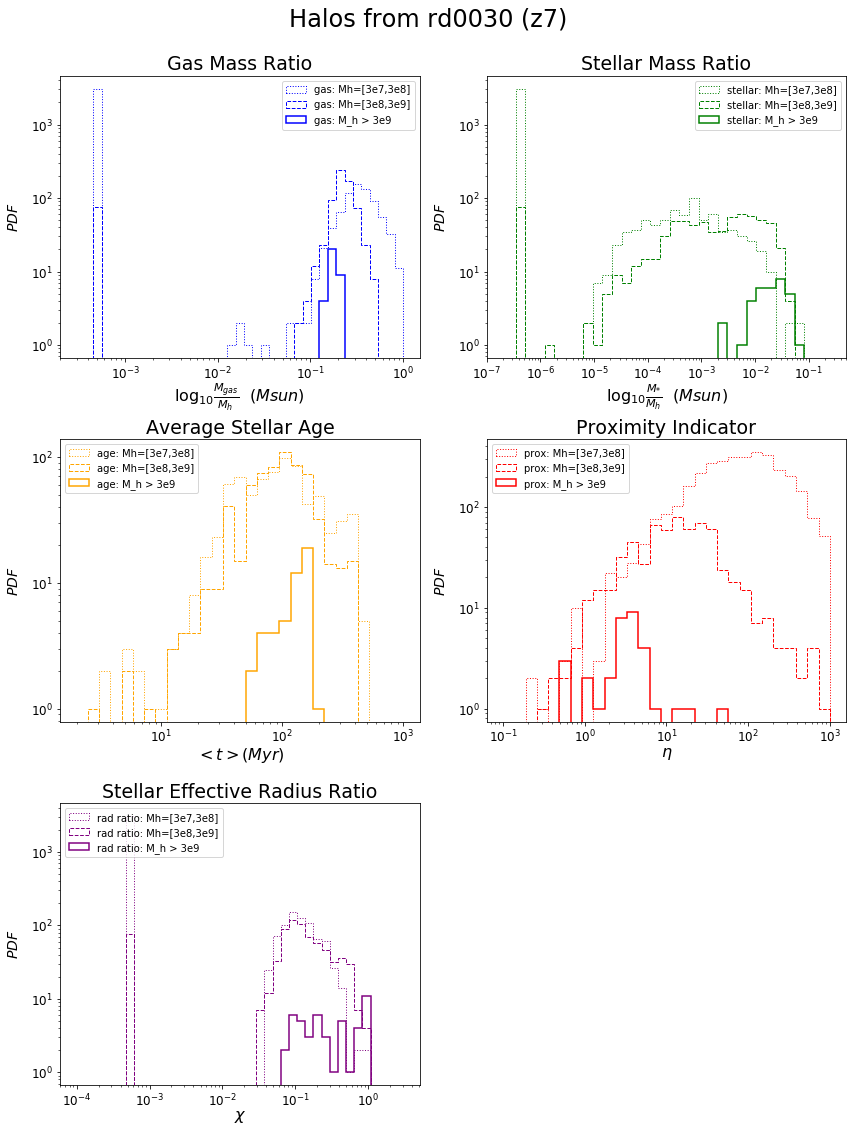

In [553]:
# create subplots
fig1 = plt.figure(figsize = (12,16))
ax1 = plt.subplot(3,2,1)
ax2 = plt.subplot(3,2,2)
ax3 = plt.subplot(3,2,3)
ax4 = plt.subplot(3,2,4)
ax5 = plt.subplot(3,2,5)

# plot titles
figtitle = "Halos from rd0030 (z7)"
gastitle = "Gas Mass Ratio"
stellartitle = "Stellar Mass Ratio"
agetitle = "Average Stellar Age"
proxtitle = "Proximity Indicator"
radtitle = "Stellar Effective Radius Ratio"

# plot various lists
ratiolists = [ratiolist1, ratiolist2]
ax1.hist(new_ratiolist11, gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax1.hist(new_ratiolist12, gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax1.hist(new_ratiolist13, gasbins, ec = 'blue', lw = 1.5, label = 'gas: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax2.hist(new_ratiolist21, stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax2.hist(new_ratiolist22, stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax2.hist(new_ratiolist23, stelbins, ec = 'green', lw = 1.5, label = 'stellar: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax3.hist(ave_agelist1, agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax3.hist(ave_agelist2, agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax3.hist(ave_agelist3, agebins, ec = 'orange', lw = 1.5, label = 'age: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax4.hist(proxlist1, proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax4.hist(proxlist2, proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax4.hist(proxlist3, proxbins, ec = 'red', lw = 1.5, label = 'prox: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax5.hist(rad_ratiolist1, radbins, ec = 'purple', lw = 1, label = 'rad ratio: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax5.hist(rad_ratiolist2, radbins, ec = 'purple', lw = 1, label = 'rad ratio: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax5.hist(rad_ratiolist3, radbins, ec = 'purple', lw = 1.5, label = 'rad ratio: M_h > 3e9', linestyle = "-", histtype='step', fill = False)

# set title
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(gastitle, size = 19)
ax2.set_title(stellartitle, size = 19)
ax3.set_title(agetitle, size = 19)
ax4.set_title(proxtitle, size = 19)
ax5.set_title(radtitle, size = 19)
#ax1.axis([1e-4, 10**1.5, 0, 700])

# create axis labels
gaslab = r"$\log_{10}\frac{M_{gas}}{M_h}$  $(Msun)$"
stellab = r"$\log_{10}\frac{M_{*}}{M_h}$  $(Msun)$"
agelab = r"$<t> (Myr)$"
proxlab = r"$\eta$"
radlab = r"$\chi$"
ylab = "$PDF$"
ax1.set_xlabel(gaslab, size = 16, labelpad= 0)
ax2.set_xlabel(stellab, size = 16, labelpad= 0)
ax3.set_xlabel(agelab, size = 16, labelpad= 0)
ax4.set_xlabel(proxlab, size = 16, labelpad= 0)
ax5.set_xlabel(radlab, size = 16, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax2.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax3.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax4.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax5.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)

# create axis ticks 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.tick_params(axis='x', which='major', labelsize=12)
ax5.tick_params(axis='y', which='major', labelsize=12)


# add labels for each plot
# annotation1 = 'using .sum'
# annotation2 = 'using particle mask'
# ax1.text(start, 20, annotation1, size = 12)
# ax2.text(start, 30, annotation2, size = 12)

# set axis limits
ax2.set_xlim([1e-7, 0.5])

# add legend
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper left')
ax4.legend(loc = 'upper left')
ax5.legend(loc = 'upper left')

# adjust spacing and show
plt.tight_layout()
fig1.subplots_adjust(top=0.92)
plt.show()

#plt.savefig('./LG4_2048_40pc/rd0070/massratios.png', dpi = 300)

In [505]:
new_logratio21 = np.log([value for value in new_ratiolist21 if value > 0]) / log(10)
new_logratio22 = np.log([value for value in new_ratiolist22 if value > 0]) / log(10)
new_logratio23 = np.log([value for value in new_ratiolist23 if value > 0]) / log(10)

age_log1 = np.log([value for value in ave_agelist1 if value > 0]) / log(10)
age_log2 = np.log([value for value in ave_agelist2 if value > 0]) / log(10)
age_log3 = np.log([value for value in ave_agelist3 if value > 0]) / log(10)
plot_agelog1 = 3**(age_log1**2)/10
plot_agelog2 = 3**(age_log2**2)/10
plot_agelog3 = 3**(age_log3**2)/10

In [506]:
plot_agelog1

array([  7.33183494,   1.39568457,  48.39077363, ...,   0.1       ,
         0.1       ,   0.1       ])

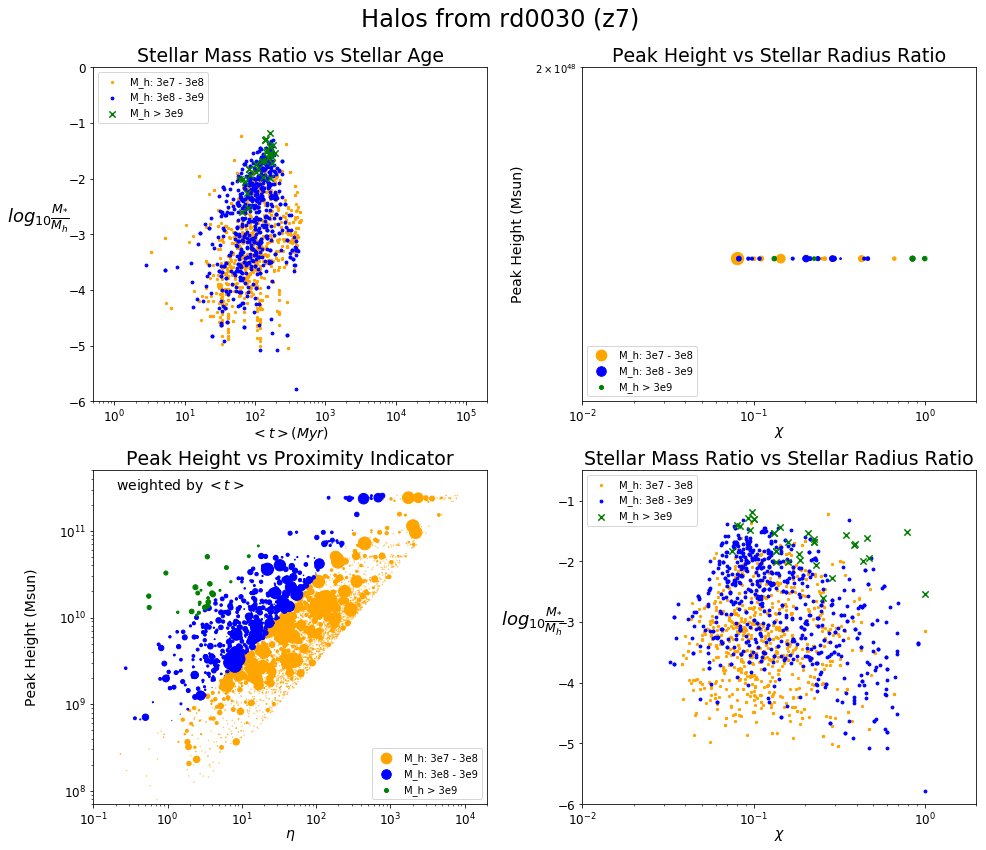

In [548]:
# specify figure size
fig2 = plt.figure(figsize=(14,12))
ax1 = fig2.add_subplot(221)
ax2 = fig2.add_subplot(222)
ax3 = fig2.add_subplot(223)
ax4 = fig2.add_subplot(224)

# create plot titles
agetitle = "Stellar Mass Ratio vs Stellar Age"
peaktitle = "Peak Height vs Stellar Radius Ratio"
proxpeaktitle = "Peak Height vs Proximity Indicator"
radratiotitle = "Stellar Mass Ratio vs Stellar Radius Ratio"

# set titles
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(agetitle, size = 19)
ax2.set_title(peaktitle, size = 19)
ax3.set_title(proxpeaktitle, size = 19)
ax4.set_title(radratiotitle, size = 19)

# # --determine line of best fit
# # reduce range of values to fit line
# bin_edges_fit1 = bin_edges1[8:-10]
# bin_edges_fit2 = bin_edges2[16:-4]
# log_density_fit1 = log_density1[7:-10]
# log_density_fit2 = log_density2[15:-4]
# # determine line
# par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
# par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
# slope1, intercept1 = par1[0][0], par1[0][1]
# slope2, intercept2 = par2[0][0], par2[0][1]

# plot data 
ax1.scatter(ave_agelist1, new_logratio21, c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax1.scatter(ave_agelist2, new_logratio22, c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax1.scatter(ave_agelist3, new_logratio23, c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')

ax2.scatter(rad_ratiolist1, new_peaklist1, c = 'orange', s = plot_agelog1, cmap='binary', label = 'M_h: 3e7 - 3e8')
ax2.scatter(rad_ratiolist2, new_peaklist2, c = 'blue', s = plot_agelog2, cmap='binary', label = 'M_h: 3e8 - 3e9')
ax2.scatter(rad_ratiolist3, new_peaklist3, c = 'green', s = plot_agelog3, cmap='binary', label = 'M_h > 3e9')

ax3.scatter(proxlist1, new_peaklist1, c = 'orange', s = plot_agelog1, cmap='binary', label = 'M_h: 3e7 - 3e8')
ax3.scatter(proxlist2, new_peaklist2, c = 'blue', s = plot_agelog2, cmap='binary', label = 'M_h: 3e8 - 3e9')
ax3.scatter(proxlist3, new_peaklist3, c = 'green', s = plot_agelog3, cmap='binary', label = 'M_h > 3e9')

ax4.scatter(rad_ratiolist1, new_logratio21, c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax4.scatter(rad_ratiolist2, new_logratio22, c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax4.scatter(rad_ratiolist3, new_logratio23, c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')
# ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
# ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')

# create axis labels
agelab = "$<t> (Myr)$"
proxlab = r"$\eta$"
radlab = r"$\chi$"
peaklab = "Peak Height (Msun)"
ylab = r"$log_{10}\frac{M_{*}}{M_h}$"
ax1.set_xlabel(agelab, size = 14, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 30)
ax2.set_xlabel(radlab, size = 14, labelpad= 0)
ax2.set_ylabel(peaklab, rotation = 90, size = 14, labelpad= 10)
ax3.set_xlabel(proxlab, size = 14, labelpad= 0)
ax3.set_ylabel(peaklab, rotation = 90, size = 14, labelpad= 20)
ax4.set_xlabel(radlab, size = 14, labelpad= 0)
ax4.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 25)

# create axis ticks and set axis lim
ax1.set_xscale('log')
ax1.set_xlim([5e-1, 2e5])
ax1.set_ylim([-6, 0])
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1e-2, 2e0])
ax2.set_ylim([1.85e48, 2e48])
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([1e-1,2e4])
ax3.set_ylim([7e7, 5e11])
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)

ax4.set_xscale('log')
ax4.set_xlim([1e-2, 2e0])
ax4.set_ylim([-6, -0.5])
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)

# add annotation
annotation = r"weighted by $<t>$"
ax3.text(2e-1, 3e11, annotation, size = 14)

# add legend
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower left')
ax3.legend(loc = 'lower right')
ax4.legend(loc = 'upper left')

# adjust spacing and show
plt.tight_layout()
fig2.subplots_adjust(top=0.91)
plt.show()

# 7-12, 26-27, 24-32, 45-53

In [452]:
# convert lists to np arrays
ratioarray1 = np.array(new_ratiolist21)
ratioarray2 = np.array(new_ratiolist22)
ratioarray3 = np.array(new_ratiolist23)
agelog1 = np.log(ave_agelist1) / log(10)
agelog2 = np.log(ave_agelist2) / log(10)
agelog3 = np.log(ave_agelist3) / log(10)


# find stdev for lists
stdevratio1 = np.std(new_logratio21[new_logratio21 > -6])
stdevratio2 = np.std(new_logratio22[new_logratio22 > -6])
stdevratio3 = np.std(new_logratio23[new_logratio23 > -6])

stdevage1 = np.std(agelog1[0 < agelog1])
stdevage2 = np.std(agelog2[0 < agelog2])
stdevage3 = np.std(agelog3[0 < agelog3])

# find mean and medians for lists
meanratio1 = np.mean(new_logratio21[new_logratio21 > -6])
meanratio2 = np.mean(new_logratio22[new_logratio22 > -6])
meanratio3 = np.median(new_logratio23[new_logratio23 > -6])

meanage1 = np.mean(agelog1[0 < agelog1])
meanage2 = np.mean(agelog2[0 < agelog2])
meanage3 = np.median(agelog3[0 < agelog3])

In [453]:
# create corresp lists of stdev, mean, medians
masslist = [3e7, 3e8, 3e9]

ratiodevlist = [stdevratio1, stdevratio2, stdevratio3]
agedevlist = [stdevage1, stdevage2, stdevage3]

ratiomeanlist = [meanratio1, meanratio2, meanratio3]
agemeanlist = [meanage1, meanage2, meanage3]

In [454]:
print(ratiomeanlist)
print(ratiodevlist)
print(agemeanlist)
print(agedevlist)

[-3.2843315191123574, -2.7556128891453073, -1.6853447916460855]
[0.75109745779841497, 0.80332221129882297, 0.33013826980324279]
[1.9450679701195561, 1.9645075383044319, 2.1437796633831536]
[0.34897049894105231, 0.28450211613852616, 0.1417706779145414]


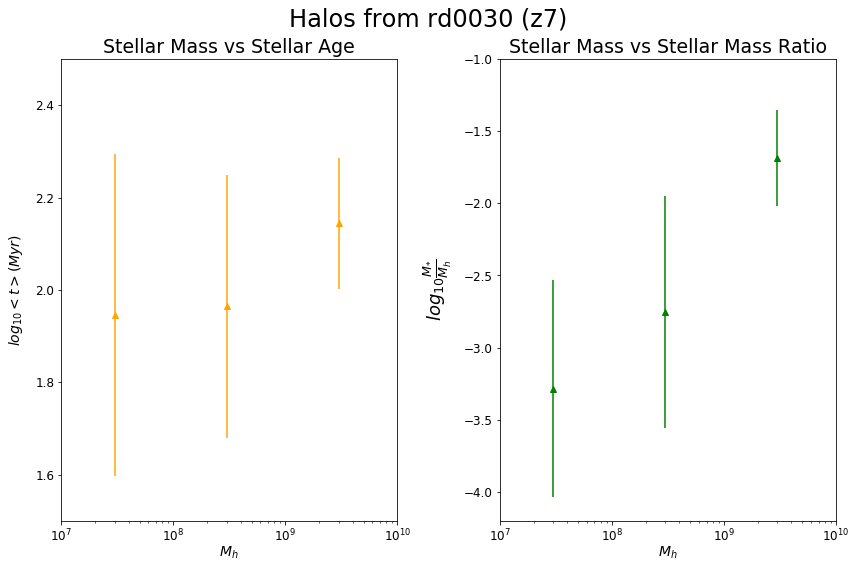

In [463]:
# specify figure size
fig3 = plt.figure(figsize=(12,8))
ax1 = fig3.add_subplot(121)
ax2 = fig3.add_subplot(122)

# create plot titles
agetitle = "Stellar Mass vs Stellar Age"
massratiotitle = "Stellar Mass vs Stellar Mass Ratio"

# set plot titles
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(agetitle, size = 19)
ax2.set_title(massratiotitle, size = 19)

# create plots
ax1.errorbar(masslist, agemeanlist, agedevlist, c = 'orange', marker="^", linestyle='None')
ax2.errorbar(masslist, ratiomeanlist, ratiodevlist, c = 'green', marker="^", linestyle='None')

# create axis labels
agelab = "$log_{10}<t> (Myr)$"
ratiolab = r"$log_{10}\frac{M_{*}}{M_h}$"
masslab = r"$M_h$"
ax1.set_xlabel(masslab, size = 14, labelpad= 0)
ax1.set_ylabel(agelab, rotation = 90, size = 14, labelpad= 10)
ax2.set_xlabel(masslab, size = 14, labelpad= 0)
ax2.set_ylabel(ratiolab, rotation = 90, size = 18, labelpad= 10)

# create axis ticks 
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

# set axis limits
ax1.set_xlim([1e7, 1e10])
ax1.set_ylim([1.5, 2.5])
ax2.set_xlim([1e7, 1e10])
ax2.set_ylim([-4.2, -1])

# adjust spacing and show
plt.tight_layout()
fig3.subplots_adjust(top=0.89)
plt.show()

In [124]:
# find log arrays for ratio lists
log_ratio1 = np.log(ratiolist1) / log(10)
log_ratio2 = np.log([value for value in ratiolist2 if value > 0]) / log(10)

# find histogram parameters
density1, bin_edges1 = np.histogram(log_ratio1, bins= np.linspace(-3.5, 0.4, 39))
density2, bin_edges2 = np.histogram(log_ratio2, bins= np.linspace(-2.2, 1.1, 33))


log_density1 = np.log(density1) / log(10)
log_density2 = np.log(density2) / log(10)

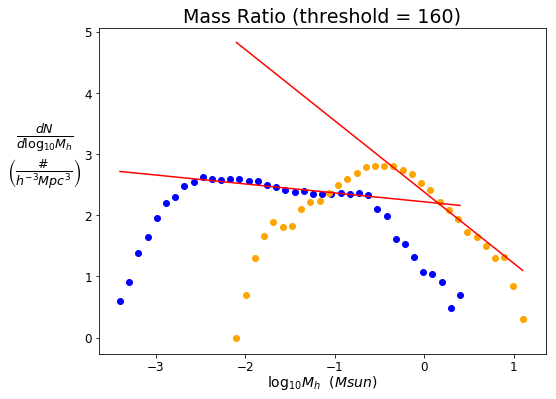

In [161]:
# specify figure size
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)

# --determine line of best fit
# reduce range of values to fit line
bin_edges_fit1 = bin_edges1[8:-10]
bin_edges_fit2 = bin_edges2[16:-4]
log_density_fit1 = log_density1[7:-10]
log_density_fit2 = log_density2[15:-4]
# determine line
par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
slope1, intercept1 = par1[0][0], par1[0][1]
slope2, intercept2 = par2[0][0], par2[0][1]

# plot data and line
bin_edges_red1 = bin_edges1[1:]
bin_edges_red2 = bin_edges2[1:]
ax2.scatter(bin_edges_red1, log_density1, color = 'blue')
ax2.scatter(bin_edges_red2, log_density2, color = 'orange')
ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')
ax2.set_title("Mass Ratio (threshold = 160)", size = 19)

# create axis labels
xlab = "$\log_{10}M_h}$  $(Msun)$"
ylab = r"$\frac{dN}{d\log_{10}M_h}$"+"\n"+r"$\left(\frac{\#}{h^{-3}Mpc^3}\right)$"
ax2.set_xlabel(xlab, size = 14, labelpad= 0)
ax2.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 40)

# create axis ticks 
ax2.set_yscale('linear')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

# add slope and intercept
# annotation = "$a = {:1.3f}$ \n$b = {:1.3f}$".format(slope, intercept)
# plt.text(9.5, 1.5, annotation, size = 12)

#show and save
plt.show()